In [94]:
# Run in python console
import nltk; nltk.download('stopwords')
import spacy

import re
import os
import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import en_core_web_sm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from langdetect import detect

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

from yellowbrick.features import FeatureImportances
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.model_selection import CVScores

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [86]:
# import sys
# !{sys.executable} -m pip install yellowbrick
# # !{sys.executable} -m spacy download en_core_web_sm

     |████████████████████████████████| 103 kB 18.4 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/JupyterSystemEnv/bin/python -m pip install --upgrade pip' command.


# Understanding how listing description influence price and listing rating

The AirBnb dataset provides with features not only that have numeric or structured values but also unstructured data. To mention a few examples: the name of of the property, a short description of the space, an overview of the neighborhood and a description of the listing itself. As part of our project we would like to use Natural Language Processing techniques to understand how unstructured data available for each listing might influence price.

The reason we believe that there might be a relationship betweeen the listing description and the price is because 
we think that what makes a listing valuable is not only their features per se but also the way the place is presented to the potential guest. This, not only includes the pictures of the listing but also the words that the listing owners pick to describe their listing and assumingly seeks to attrack their potential customers. We assume that by including certain words in the description could potentially increase the attractiveness of a certain property to be rented. Thus, due to supply and demand law, can assume that the more demanded a property is, the higher the value it could have. 

To begin with the analysis we want to see if there are similarities in the way listing owners describe their place and the price they charge per night. We proceed with the assumption that listings with similar features will use similar words to describe their property. Furthermore we are curious about how words in the description could inform us about the listing's overall rating.

For this reason we will be using this notebook to try to answer the following questions:

1. Do listings using similar words in their description share a similar price?
2. Do listings using similar words in their description share other features that are relevant to predict price?
3. Do listings using similar words in their description end up having similar guest acceptance/rating?

For this purpose we will first, use Latent Dirichlet Allocation to elicit the latent topics in the description. Latent Dirichlet Allocation is an unsupervised algorithm, largely used in Natural Language Processing to perform what is known as Topic Modeling. This algorightm uses probability distribution to discover which parts of the data are similar. In the context of our project we would try to discover the similar words used the description of New York City listings that could potentially influence price.

## Importing data into DataFrame

In [3]:
path = '../data/new-york-city-airbnb-open-data/'
listings_csv = os.path.join(path,'listings.csv')

listings_df =  pd.read_csv(listings_csv,low_memory=False)

In [4]:
# Creating content column with name and description of property
listings_df['content'] = listings_df['name'] + listings_df['description']
content = listings_df[['id','content']]

As we will be able to see, the description is the single text field with fewer than 3% missing values. This is also one of the reasons why we chose to work with this field to experiment with NLP into trying to predict price.

In [25]:
summary_nulls = round((listings_df.summary.isnull().sum()/listings_df.shape[0])*100, 1)
space = round((listings_df.space.isnull().sum()/listings_df.shape[0])*100, 1)
description = round((listings_df.description.isnull().sum()/listings_df.shape[0])*100, 1)
neighborhood_overview = round((listings_df.neighborhood_overview.isnull().sum()/listings_df.shape[0])*100, 1)
notes = round((listings_df.notes.isnull().sum()/listings_df.shape[0])*100, 1)
transit = round((listings_df.transit.isnull().sum()/listings_df.shape[0])*100, 1)
access = round((listings_df.access.isnull().sum()/listings_df.shape[0])*100, 1)
interaction = round((listings_df.interaction.isnull().sum()/listings_df.shape[0])*100, 1)
house_rules = round((listings_df.house_rules.isnull().sum()/listings_df.shape[0])*100, 1)

In [24]:
print(f"{summary_nulls}% of listings have empty summaries")
print(f"{space}% of listings have empty space description")
print(f"{description}% of listings have empty description")
print(f"{neighborhood_overview}% of listings have empty overviews on their neighborhood")
print(f"{notes}% of listings have no notes from the host")
print(f"{transit}% of listings have no information on transit")
print(f"{access}% of listings have no information on accessibility")
print(f"{interaction}% of listings have no information on interaction")
print(f"{house_rules}% of listings have no information on house_rules")


4.8% of listings have empty summaries
28.0% of listings have empty space description
2.4% of listings have empty description
34.4% of listings have empty overviews on their neighborhood
59.6% of listings have no notes from the host
34.4% of listings have no information on transit
47.2% of listings have no information on accessibility
40.2% of listings have no information on interaction
39.1% of listings have no information on house_rules


Importing numeric features from previous Exploratory Data Analysis and Modeling

In [26]:
# Importing model df
model_cols_df = pd.read_csv('../data/new-york-city-airbnb-open-data/model_columns_listings.csv',index_col = 0)

In [27]:
model_cols_df.iloc[:,0:4].head()

,id,host_since,host_is_superhost,host_identity_verified
0,2595,733294,0,1
1,3831,733383,0,1
2,5099,733440,0,0
3,5121,733441,0,0
4,5178,733469,0,0


In [28]:
# Joining the new created 'content' column with the model dataframe just to choose rows that are relevant
df_model = pd.merge(left=model_cols_df, right=content, how='left', on='id')

# dropping null values
df_model = df_model.dropna()

In [29]:
df_model.iloc[:,0:4].head()

,id,host_since,host_is_superhost,host_identity_verified
0,2595,733294,0,1
1,3831,733383,0,1
2,5099,733440,0,0
3,5121,733441,0,0
4,5178,733469,0,0


## Predicting Language from content

As we may already know, AirBnb is a platform used by people from all around the world. Therefore, some hosts that want to attract guests who speak languages other than English might want to use different language or languages to describe their place. For our analysis we want to make sure that we are working with a single language and since the majority of reviews are written in English, we will use langdetect, to determine those descriptions written in English only. Langdetect is a language detection algorithm that supports 55 languages out of the box. To maximize the probability of the algorithms predicting the correct language we make sure we send it a long enough string.

In [30]:
def predict_lang(x):
    lang=''
    txt_len=len(x)
    if txt_len>50:
        try:
            lang=detect(x)
        except Exception as e:
            lang=''
    return lang

In [31]:
df_model['content_lang'] = df_model.content.apply(lambda x: predict_lang(x))

In [32]:
# getting only text in English
df_model_en_desc = df_model[df_model.content_lang=='en']

In [33]:
df_model.shape, df_model_en_desc.shape

((27354, 47), (27106, 47))

In [34]:
df_model_en_desc.iloc[:,0:4].head()

,id,host_since,host_is_superhost,host_identity_verified
0,2595,733294,0,1
1,3831,733383,0,1
2,5099,733440,0,0
3,5121,733441,0,0
4,5178,733469,0,0


## LDA for Topic Modeling in Listing Description

In [35]:
def generate_list_content(df):
#     df['content'] = df['name'] + df['summary']
#     df['content'] = df['content'].replace(np.nan, '', regex=True)
    
    # Convert to list
    data = df['content'].values.tolist()

    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    
    
    return data

In [36]:
lst_texts = generate_list_content(df_model_en_desc)

In [37]:
len(lst_texts)

27106

## Tokenize words and clean up text

In [38]:
# here we are tokenizing each document.
def content_to_words(lst_texts):
    for text in lst_texts:
        yield(gensim.utils.simple_preprocess(str(text), deacc=True))
        
# data_words is a list where each element is the tokenized document
tokenized_content = list(content_to_words(lst_texts))

## Create bigram and trigrams

In [39]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_content, min_count=10, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_content], threshold=100)  


# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

## Remove Stopwords, Make Bigrams and Lemmatize

In [40]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(tokenized_content):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in tokenized_content]

def make_bigrams(tokenized_content):
    return [bigram_mod[doc] for doc in tokenized_content]

def make_trigrams(tokenized_content):
    return [trigram_mod[bigram_mod[doc]] for doc in tokenized_content]

def lemmatization(tokenized_content, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in tokenized_content:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

In [41]:
# Remove Stop Words
tokenized_content_nostops = remove_stopwords(tokenized_content)

# Form Bigrams
tokenized_content_bigrams = make_bigrams(tokenized_content_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
tokenized_content_lemmatized = lemmatization(tokenized_content_bigrams, 
                                             allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

## Create the Dictionary and Corpus needed for Topic Modeling

In [42]:
# Create Dictionary:
# Mapping from word IDs to words. 
# It is used to determine the vocabulary size, as well as for debugging and topic printing.
id2word = corpora.Dictionary(tokenized_content_lemmatized)
# print(len(id2word)) # corpus has 14118 unique tokens

# Term Document Frequency
# Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples.
# Word with their corresponding id
corpus = [id2word.doc2bow(text) for text in tokenized_content_lemmatized]

# View
# print(corpus[:1])

The biggest challenge of using LDA for Topic Modeling is determining the right amount of topics *n*. Therefore we will use two metrics: Perplexity and Coherence as well as the pyLDAvis to approximately determine the right number of topics that are latent in our corpus (description).

## Build list of topic models

In [43]:
def build_topics(num_topics):
    list_models=[]
    for n in num_topics:
        topic_name = 'lda_model_' + str(n)
        topic_name = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                                     num_topics=n, random_state=100, 
                                                     update_every=1, chunksize=100, 
                                                     passes=10, alpha='auto', 
                                                     per_word_topics=True)
        list_models.append(topic_name)
    return list_models

num_topics = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
models = build_topics(num_topics)

In [116]:
## Saving the models to disc
from gensim.test.utils import datapath

# Save model to disk.
for i in range(len(models)):
    temp_file = datapath("model" + str(i))
    models[i].save(temp_file)

In [ ]:
# Load a potentially pretrained model from disk.
# lda = LdaModel.load(temp_file)

## Compute Model Perplexity and Coherence Score for all models

According to (Jansen, 2018) Perplexity when applied to LDA meassures how well the topic-word probability distribution recovered by the model predicts a sample, for example, unseen text documents. It is based on the entropy H(p) of this distribution p and computed with respect to the set of tokens w. Measures closer to zero imply the distribution is better at predicting the sample.

In terms of Coherence, we will be using Gensim implementation based on the paper writen by (Roder, et al., 2015). Larger scores in coherence mean better topic representation of the corpus.

## Bibliography

Jansen, S. (2018). Perplexity. In Hands-on machine learning for algorithmic trading: Design and implement investment strategies based on smart algorithms that learn from data using Python. Birmingham: Packt Publishing.

Roder, M., Both, A., and Hinneburg, A. (2015). Exploring the Space of Topic Coherence Measures. In Proceedings of the Eighth ACM International Conference on Web Search and Data Mining, WSDM ’15, pages 399–408, New York, NY, USA. ACM.

In [45]:
def calc_perplexity_coherence(models):
    list_perplexity = []
    list_coherence = []
    
    for model in models:
        list_perplexity.append(model.log_perplexity(corpus))
        coherence_model_lda = CoherenceModel(model=model, texts=tokenized_content_lemmatized, 
                                             dictionary=id2word, coherence='c_v')
        list_coherence.append(coherence_model_lda.get_coherence())
    return list_perplexity, list_coherence

x = calc_perplexity_coherence(models)      

In [46]:
df_metrics = pd.DataFrame(list(x)).transpose()
df_metrics.columns = ['Perplexity','Coherence']
df_metrics['Number of topics'] = num_topics
df_metrics

,Perplexity,Coherence,Number of topics
0,-6.710409,0.389050,2
1,-6.683156,0.478600,3
2,-6.683335,0.472871,4
3,-6.695626,0.521508,5
4,-6.720919,0.476990,6
5,-6.750671,0.420318,7
6,-6.784542,0.411547,8
7,-6.830094,0.469787,9
8,-6.929373,0.386585,10
9,-7.090426,0.370052,11


## Graphic of number of Topics and Perplexity

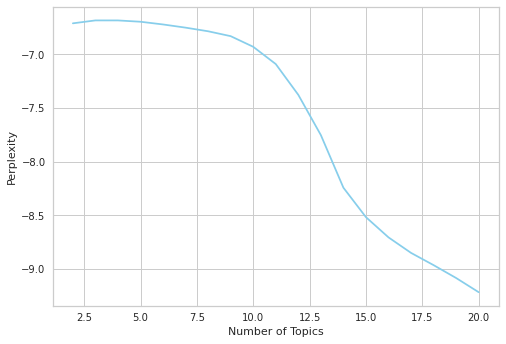

In [47]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Perplexity', data=df_metrics, color='skyblue')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.show()

## Graphic of number of Topics and Coherence

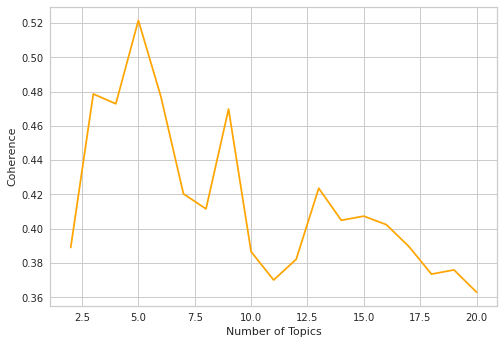

In [48]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Coherence', data=df_metrics, color='orange')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.show()

## Visualizing topics accordint to the best *n*

### Five topics

In [65]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_5 = pyLDAvis.gensim.prepare(models[3], corpus, id2word)
vis_5

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      29.235531        1       1 -0.062641  0.046274
2      28.722229        1       2 -0.192002 -0.172951
3      26.221720        1       3  0.013380 -0.195510
1      13.652073        1       4 -0.133836  0.291872
0       2.168442        1       5  0.375098  0.030314, topic_info=      Category          Freq                 Term         Total  loglift  \
term                                                                       
293    Default  12565.000000                 stay  12565.000000  30.0000   
145    Default  21889.000000                 walk  21889.000000  29.0000   
102    Default  39770.000000                 room  39770.000000  28.0000   
109    Default  17663.000000                train  17663.000000  27.0000   
96     Default  16854.000000               minute  16854.000000  26.0000   
8      Default  16899.000000                  bed  16899.000000  25.0000   
66     Default  27930.000000              bedroom  27930.000000  24.0000   
221    Default  16295.000000           restaurant  16295.000000  23.0000   
202    Default  15305.000000             bathroom  15305.000000  22.0000   
200    Default  15451.000000                 away  15451.000000  21.0000   
186    Default  15950.000000                space  15950.000000  20.0000   
22     Default  12728.000000                 full  12728.000000  19.0000   
370    Default   9102.000000                clean   9102.000000  18.0000   
67     Default  11439.000000                block  11439.000000  17.0000   
90     Default  17022.000000                guest  17022.000000  16.0000   
99     Default  19820.000000              private  19820.000000  15.0000   
38     Default   6223.000000               modern   6223.000000  14.0000   
29     Default  10186.000000              kitchen  10186.000000  13.0000   
131    Default   9457.000000               living   9457.000000  12.0000   
205    Default   9227.000000                close   9227.000000  11.0000   
234    Default   9166.000000                  bar   9166.000000  10.0000   
385    Default   5956.000000              provide   5956.000000   9.0000   
21     Default  11576.000000                floor  11576.000000   8.0000   
246    Default   6505.000000                fully   6505.000000   7.0000   
312    Default  11291.000000                 home  11291.000000   6.0000   
113    Default  42346.000000            apartment  42346.000000   5.0000   
204    Default   3995.000000                check   3995.000000   4.0000   
31     Default   5184.000000                light   5184.000000   3.0000   
142    Default   8054.000000               subway   8054.000000   2.0000   
243    Default   5013.000000                equip   5013.000000   1.0000   
...        ...           ...                  ...           ...      ...   
5539    Topic5    213.526291            technique    214.392761   3.8271   
14592   Topic5    213.525833  proper_disinfection    214.392334   3.8271   
14595   Topic5    213.525833          uncertainty    214.392334   3.8271   
1513    Topic5    211.067841                woman    211.977646   3.8269   
1308    Topic5    205.927490               health    206.824020   3.8268   
165     Topic5    199.008682                 last    199.907547   3.8267   
1910    Topic5    194.055710                video    194.949997   3.8266   
1386    Topic5    270.055328              combine    273.092712   3.8200   
3051    Topic5    561.024475             interact    600.622803   3.7630   
210     Topic5    359.371735               expect    544.100830   3.4164   
854     Topic5    539.116577                  run   1108.797119   3.1101   
293     Topic5   1547.453125                 stay  12565.755859   1.7368   
2709    Topic5    457.067902            essential   1116.803467   2.9378   
204     Topic5    730.608765                check   3995.066406   2.1322   
261    

In [66]:
pyLDAvis.save_html(vis_5, '../data/visualization_5_topics.html')

In [67]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_7 = pyLDAvis.gensim.prepare(models[5], corpus, id2word)
vis_7

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      28.381079        1       1 -0.165803 -0.172109
4      28.368122        1       2 -0.214351 -0.077046
2      27.180204        1       3 -0.216016  0.073514
1      11.263128        1       4 -0.133221  0.244426
0       1.991019        1       5  0.189989 -0.263629
5       1.675411        1       6  0.258939  0.054283
6       1.141030        1       7  0.280463  0.140561, topic_info=     Category          Freq          Term         Total  loglift  logprob
term                                                                     
145   Default  22072.000000          walk  22072.000000  30.0000  30.0000
66    Default  27995.000000       bedroom  27995.000000  29.0000  29.0000
293   Default  12834.000000          stay  12834.000000  28.0000  28.0000
102   Default  39660.000000          room  39660.000000  27.0000  27.0000
109   Default  17811.000000         train  17811.000000  26.0000  26.0000
96    Default  16995.000000        minute  16995.000000  25.0000  25.0000
221   Default  16432.000000    restaurant  16432.000000  24.0000  24.0000
8     Default  16774.000000           bed  16774.000000  23.0000  23.0000
200   Default  15580.000000          away  15580.000000  22.0000  22.0000
202   Default  15220.000000      bathroom  15220.000000  21.0000  21.0000
90    Default  16992.000000         guest  16992.000000  20.0000  20.0000
22    Default  12633.000000          full  12633.000000  19.0000  19.0000
99    Default  19821.000000       private  19821.000000  18.0000  18.0000
370   Default   9256.000000         clean   9256.000000  17.0000  17.0000
67    Default  11535.000000         block  11535.000000  16.0000  16.0000
312   Default  11262.000000          home  11262.000000  15.0000  15.0000
21    Default  11599.000000         floor  11599.000000  14.0000  14.0000
204   Default   4094.000000         check   4094.000000  13.0000  13.0000
385   Default   5976.000000       provide   5976.000000  12.0000  12.0000
38    Default   6255.000000        modern   6255.000000  11.0000  11.0000
246   Default   6482.000000         fully   6482.000000  10.0000  10.0000
205   Default   9304.000000         close   9304.000000   9.0000   9.0000
234   Default   9243.000000           bar   9243.000000   8.0000   8.0000
113   Default  42033.000000     apartment  42033.000000   7.0000   7.0000
116   Default   7695.000000      building   7695.000000   6.0000   6.0000
131   Default   9387.000000        living   9387.000000   5.0000   5.0000
29    Default  10109.000000       kitchen  10109.000000   4.0000   4.0000
31    Default   5237.000000         light   5237.000000   3.0000   3.0000
257   Default  11806.000000  neighborhood  11806.000000   2.0000   2.0000
60    Default   4485.000000         towel   4485.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
1412   Topic7   1013.459473      anywhere   1014.382324   4.4723  -2.9785
1416   Topic7    545.409790          kind    546.331848   4.4715  -3.5981
881    Topic7    521.711426     literally    522.632874   4.4715  -3.6425
816    Topic7    481.139130         oasis    482.061279   4.4713  -3.7235
2105   Topic7    448.181152          ever    449.104370   4.4712  -3.7944
2006   Topic7    421.007965    everywhere    421.930481   4.4710  -3.8570
1426   Topic7    401.904388       hipster    402.827301   4.4709  -3.9034
1715   Topic7    366.998474       astoria    367.920593   4.4707  -3.9943
1948   Topic7    348.006256  construction    348.948334   4.4705  -4.0474
806    Topic7    339.239777       cuisine    340.161652   4.4705  -4.0729
420    Topic7    307.322205     adventure    308.245697   4.4702  -4.1717
1628   Topic7    303.829285        garage    304.753357   4.4702  -4.1832
874    Topic7    297.641968     delicious    298.564545   4.4701  -4.2037
1427   Topic7    289.855011          lirr    290.777435   4.4701  -

In [68]:
pyLDAvis.save_html(vis_7, '../data/visualization_7_topics.html')

In [69]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_9 = pyLDAvis.gensim.prepare(models[7], corpus, id2word)
vis_9

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      21.174509        1       1 -0.144337 -0.117737
2      20.901030        1       2 -0.225574  0.095726
4      19.235279        1       3 -0.130556 -0.003861
6      10.408291        1       4 -0.168553  0.304603
3      10.272223        1       5 -0.029921 -0.173007
8       8.608661        1       6  0.054822 -0.202527
1       5.876636        1       7  0.085320 -0.175190
5       2.616107        1       8  0.287441  0.155677
0       0.907271        1       9  0.271356  0.116316, topic_info=      Category          Freq                 Term         Total  loglift  \
term                                                                       
102    Default  41000.000000                 room  41000.000000  30.0000   
66     Default  28653.000000              bedroom  28653.000000  29.0000   
109    Default  18175.000000                train  18175.000000  28.0000   
96     Default  17343.000000               minute  17343.000000  27.0000   
200    Default  15899.000000                 away  15899.000000  26.0000   
113    Default  41351.000000            apartment  41351.000000  25.0000   
21     Default  12199.000000                floor  12199.000000  24.0000   
145    Default  22670.000000                 walk  22670.000000  23.0000   
221    Default  16929.000000           restaurant  16929.000000  22.0000   
8      Default  16997.000000                  bed  16997.000000  21.0000   
67     Default  11778.000000                block  11778.000000  20.0000   
202    Default  15481.000000             bathroom  15481.000000  19.0000   
99     Default  20641.000000              private  20641.000000  18.0000   
293    Default  12704.000000                 stay  12704.000000  17.0000   
22     Default  12804.000000                 full  12804.000000  16.0000   
32     Default  14748.000000               locate  14748.000000  15.0000   
90     Default  17205.000000                guest  17205.000000  14.0000   
183    Default  10984.000000                share  10984.000000  13.0000   
556    Default   6884.000000                  new   6884.000000  12.0000   
6      Default  12476.000000            available  12476.000000  11.0000   
97     Default   9781.000000                 need   9781.000000  10.0000   
29     Default  10266.000000              kitchen  10266.000000   9.0000   
62     Default   6351.000000                   tv   6351.000000   8.0000   
176    Default   9442.000000                place   9442.000000   7.0000   
234    Default   9523.000000                  bar   9523.000000   6.0000   
31     Default   5219.000000                light   5219.000000   5.0000   
131    Default   9524.000000               living   9524.000000   4.0000   
204    Default   4178.000000                check   4178.000000   3.0000   
186    Default  16123.000000                space  16123.000000   2.0000   
257    Default  12061.000000         neighborhood  12061.000000   1.0000   
...        ...           ...                  ...           ...      ...   
1165    Topic9    817.957153              curtain    818.921387   4.7013   
1150    Topic9    596.926453         professional    597.890747   4.7009   
835     Topic9    488.074371                ferry    489.038574   4.7005   
14594   Topic9    476.995239               sonder    477.959106   4.7005   
14593   Topic9    443.605072                 sond    444.568939   4.7003   
843     Topic9    434.857117                  put    435.821533   4.7003   
403     Topic9    431.969788               hanger    432.934143   4.7003   
2894    Topic9    399.942505                 code    400.907104   4.7001   
1745    Topic9    358.242798                other    359.207184   4.6998   
731     Topic9    331.274780               attach    332.239380   4.6996   
146     Topic9    329.855804               arrive    330.820068   4.6996   
1784    Topic9    3

In [70]:
pyLDAvis.save_html(vis_9, '../data/visualization_9_topics.html')

## Creating DataFrame with scores and topics for 5 topics

In [52]:
# function that returns data frame with 
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=lst_texts):
    # Init output
    sent_topics_df = list()
#     df_model_en_desc.reset_index(inplace=True)
    
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
#         print(row)
        sent_topics_df.append(row)
        
    sent_topics_df = pd.DataFrame(sent_topics_df)
    sent_topics_df.columns = ['Dominant_Topic_1', 'Dominant_Topic_2', 'Dominant_Topic_3','Dominant_Topic_4','Dominant_Topic_5']
    sent_topics_df = pd.concat([df_model_en_desc['id'],sent_topics_df], axis=1)
    df_n_cols = sent_topics_df.shape[1]
    
    return sent_topics_df, df_n_cols

In [53]:
sent_topics_df, df_n_cols = format_topics_sentences(ldamodel=models[3], corpus=corpus, texts=lst_texts)

In [54]:
sent_topics_df.head()

,id,Dominant_Topic_1,Dominant_Topic_2,Dominant_Topic_3,Dominant_Topic_4,Dominant_Topic_5
0,2595.0,"(1, 0.43181944)","(4, 0.41875055)","(2, 0.095193185)","(3, 0.052078165)",None
1,3831.0,"(4, 0.44952524)","(3, 0.2192561)","(1, 0.19868994)","(2, 0.12994526)",None
2,5099.0,"(4, 0.4446007)","(2, 0.29668882)","(1, 0.2171981)","(3, 0.0393152)",None
3,5121.0,"(3, 0.5458189)","(0, 0.26138443)","(2, 0.07747725)","(1, 0.0589012)","(4, 0.056418218)"
4,5178.0,"(4, 0.50688666)","(3, 0.24341352)","(2, 0.19195738)","(1, 0.031025914)","(0, 0.026716504)"


In [55]:
sent_topics_df.shape

(27855, 6)

In [56]:
sent_topics_df = sent_topics_df.dropna()

In [57]:
sent_topics_df.shape

(10307, 6)

### Separating the Topic from its score

In [58]:
for i in range(1,df_n_cols):
    top_col = 'topic' + str(i)
    score_col = 'score_dom_topic_' + str(i)
    sent_topics_df[top_col] = pd.DataFrame(sent_topics_df.iloc[:,i].tolist(), index=sent_topics_df.index)[0]
    sent_topics_df[score_col] = pd.DataFrame(sent_topics_df.iloc[:,i].tolist(), index=sent_topics_df.index)[1]

In [59]:
sent_topics_df.head()

,id,Dominant_Topic_1,Dominant_Topic_2,Dominant_Topic_3,Dominant_Topic_4,Dominant_Topic_5,topic1,score_dom_topic_1,topic2,score_dom_topic_2,topic3,score_dom_topic_3,topic4,score_dom_topic_4,topic5,score_dom_topic_5
3,5121.0,"(3, 0.5458189)","(0, 0.26138443)","(2, 0.07747725)","(1, 0.0589012)","(4, 0.056418218)",3,0.545819,0,0.261384,2,0.077477,1,0.058901,4,0.056418
4,5178.0,"(4, 0.50688666)","(3, 0.24341352)","(2, 0.19195738)","(1, 0.031025914)","(0, 0.026716504)",4,0.506887,3,0.243414,2,0.191957,1,0.031026,0,0.026717
5,5238.0,"(2, 0.42212516)","(3, 0.20713618)","(1, 0.19766873)","(4, 0.15185618)","(0, 0.02121371)",2,0.422125,3,0.207136,1,0.197669,4,0.151856,0,0.021214
10,6848.0,"(4, 0.657404)","(3, 0.16298485)","(2, 0.116142824)","(1, 0.041097235)","(0, 0.022371046)",4,0.657404,3,0.162985,2,0.116143,1,0.041097,0,0.022371
15,8490.0,"(4, 0.40794793)","(3, 0.3071768)","(1, 0.17648454)","(2, 0.0793006)","(0, 0.029090194)",4,0.407948,3,0.307177,1,0.176485,2,0.079301,0,0.029090


In [60]:
# Dropping columns with tuples
cols_2_drop = ['Dominant_Topic_1', 'Dominant_Topic_2','Dominant_Topic_3','Dominant_Topic_4','Dominant_Topic_5']
sent_topics_df.drop(columns=cols_2_drop, inplace=True)

In [61]:
sent_topics_df.head()

,id,topic1,score_dom_topic_1,topic2,score_dom_topic_2,topic3,score_dom_topic_3,topic4,score_dom_topic_4,topic5,score_dom_topic_5
3,5121.0,3,0.545819,0,0.261384,2,0.077477,1,0.058901,4,0.056418
4,5178.0,4,0.506887,3,0.243414,2,0.191957,1,0.031026,0,0.026717
5,5238.0,2,0.422125,3,0.207136,1,0.197669,4,0.151856,0,0.021214
10,6848.0,4,0.657404,3,0.162985,2,0.116143,1,0.041097,0,0.022371
15,8490.0,4,0.407948,3,0.307177,1,0.176485,2,0.079301,0,0.029090


In [62]:
# Formatting DataFrame
sent_topics_df.rename(columns={"topic1": "winner_topic",
                               "score_dom_topic_1":"winner_topic_score",
                               "topic2": "second_place_topic",
                               "score_dom_topic_2":"second_topic_score",
                               "topic3": "third_place_topic",
                               "score_dom_topic_3":"third_topic_score",
                               "topic4": "fourth_place_topic",
                               "score_dom_topic_4":"fourth_topic_score",
                              "topic5": "fifth_place_topic",
                               "score_dom_topic_5":"fifth_topic_score"},inplace=True)

In [63]:
sent_topics_df.head()

,id,winner_topic,winner_topic_score,second_place_topic,second_topic_score,third_place_topic,third_topic_score,fourth_place_topic,fourth_topic_score,fifth_place_topic,fifth_topic_score
3,5121.0,3,0.545819,0,0.261384,2,0.077477,1,0.058901,4,0.056418
4,5178.0,4,0.506887,3,0.243414,2,0.191957,1,0.031026,0,0.026717
5,5238.0,2,0.422125,3,0.207136,1,0.197669,4,0.151856,0,0.021214
10,6848.0,4,0.657404,3,0.162985,2,0.116143,1,0.041097,0,0.022371
15,8490.0,4,0.407948,3,0.307177,1,0.176485,2,0.079301,0,0.029090


## Modeling

In [71]:
# Merging the initial DataFrame with features with the topics DataFrame
df_model_en_desc_merged = pd.merge(left=df_model_en_desc, right=sent_topics_df, how='left', on='id')

In [72]:
df_model_en_desc_merged.iloc[:,0:6].head()

,id,host_since,host_is_superhost,host_identity_verified,is_location_exact,accommodates
0,2595,733294,0,1,0,2
1,3831,733383,0,1,1,3
2,5099,733440,0,0,0,2
3,5121,733441,0,0,0,2
4,5178,733469,0,0,1,2


In [73]:
df_model_en_desc_merged.shape

(27106, 57)

In [74]:
df_model_en_desc_merged = df_model_en_desc_merged.dropna()

In [75]:
df_model_en_desc_merged.shape

(10307, 57)

### Understanding the topic that appears as winner the most

winner_topic
0.0     232
1.0     615
2.0    3050
3.0    2970
4.0    3440
Name: winner_topic, dtype: int64


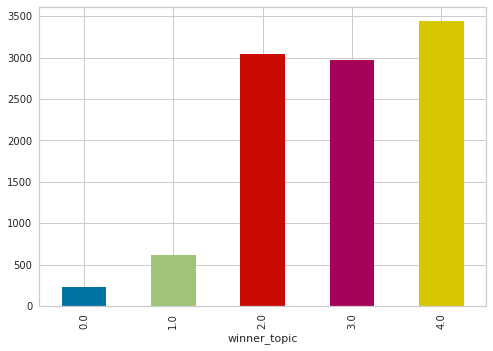

In [76]:
df = df_model_en_desc_merged.groupby('winner_topic')['winner_topic'].size()
print(df)
df.plot(kind='bar')

### Creating features X

In [77]:
X = df_model_en_desc_merged.iloc[:, 1:]
X = X.loc[:, X.columns != 'price']
X = X.loc[:, X.columns != 'content']
X = X.loc[:, X.columns != 'content_lang']

### Creating target y

In [78]:
y = df_model_en_desc_merged.price

In [ ]:
## Split train - test sets

In [79]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [80]:
# Creating a list of features to use as labels in FeatureImportances
features=list()

for col in df_model_en_desc_merged.columns:
    features.append(col)

# Removing price and id from labels
features.remove('price')
features.remove('content')
features.remove('content_lang')
features.remove('id')

In [81]:
# X_train.shape, len(features), y_train.shape

((8245, 53), 53, (8245,))

### Creating a Cross-Validation Strategy

In [96]:
# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=12, random_state=42)

## Evaluating multiple Regressors

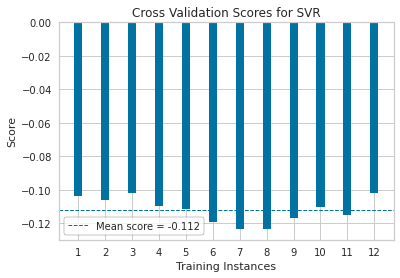

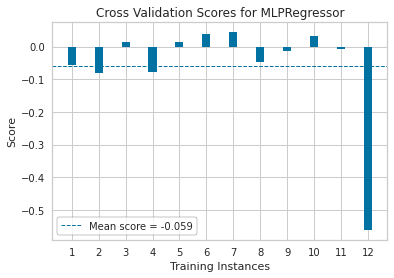

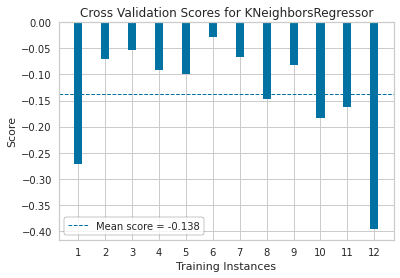

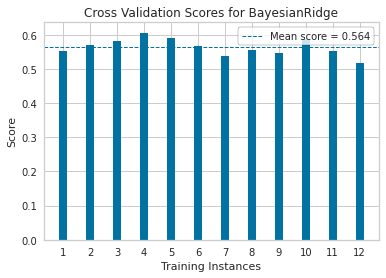

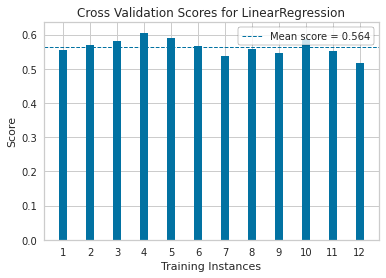

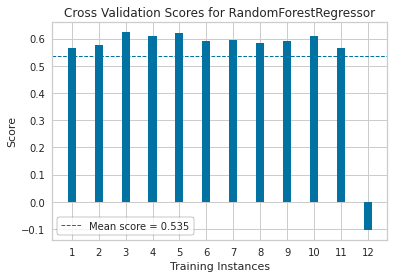

In [99]:
regressors = {
    "support vector machine": SVR(),
    "multilayer perceptron": MLPRegressor(),
    "nearest neighbors": KNeighborsRegressor(),
    "bayesian ridge": BayesianRidge(),
    "linear regression": LinearRegression(),
    "random forest": RandomForestRegressor(),
}

for _, regressor in regressors.items():
#     visualizer = ResidualsPlot(regressor)
#     visualizer.fit(X_train, y_train)
#     visualizer.score(X_test, y_test)
#     visualizer.show()
    # Instantiate the classification model and visualizer

    visualizer = CVScores(regressor, cv=cv)
    visualizer.fit(X, y)
    visualizer.show()

## Feature Importance of Baseline Random Forest

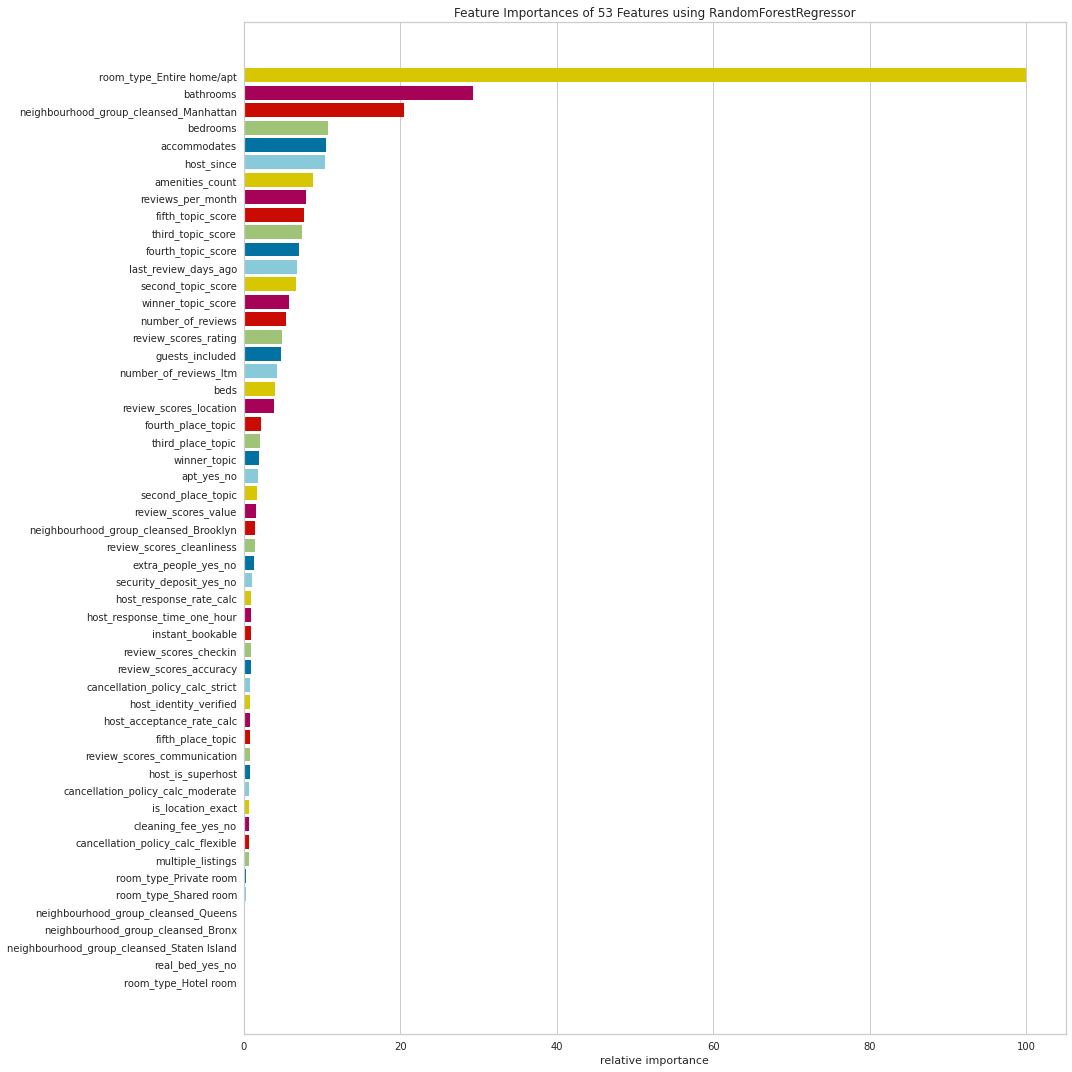

In [93]:
viz = FeatureImportances(regressors['random forest'], labels=features, size=(1080, 1080))
viz.fit(X_train, y_train)

# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.show()